# FIKH Model: Creep Response

## Learning Objectives

1. Fit FIKH to **creep (step stress)** experimental data
2. Understand **delayed yielding** and viscosity bifurcation with fractional memory
3. Analyze how **alpha_structure** affects creep acceleration
4. Explore the transition from solid-like to liquid-like behavior
5. Compare fractional vs classical creep dynamics

## Prerequisites

- NB01: FIKH Flow Curve (concepts)
- Bayesian inference fundamentals

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_ml_ikh_creep,
    save_fikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_fikh_param_names,
    plot_alpha_sweep,
    print_alpha_interpretation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Fractional Creep

Creep response under constant applied stress reveals **delayed yielding** and **viscosity bifurcation**.

### Creep Regimes

1. **Elastic response** ($t \ll \tau$): $\gamma \approx \sigma/G$
2. **Delayed yielding**: Strain accelerates as structure breaks down
3. **Steady flow** ($t \gg \tau$): $\dot{\gamma} \to \dot{\gamma}_{ss}$

### Alpha Effect on Creep

- **Lower alpha**: Slower approach to yielding, stretched acceleration
- **Higher alpha**: Sharper yield transition (classical behavior)

## 3. Load Data

In [3]:
# Load creep data from ML-IKH Excel
STRESS_PAIR = 0  # First stress jump (3 Pa → 5 Pa)
time_data, gamma_dot_data, sigma_init, sigma_final = load_ml_ikh_creep(stress_pair_index=STRESS_PAIR)

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Shear rate range: [{gamma_dot_data.min():.4g}, {gamma_dot_data.max():.4g}] 1/s")
print(f"Stress jump: {sigma_init} Pa → {sigma_final} Pa")

Data points: 70
Time range: [0.0098, 295.66] s
Shear rate range: [3.222, 6.264] 1/s
Stress jump: 3.0 Pa → 5.0 Pa


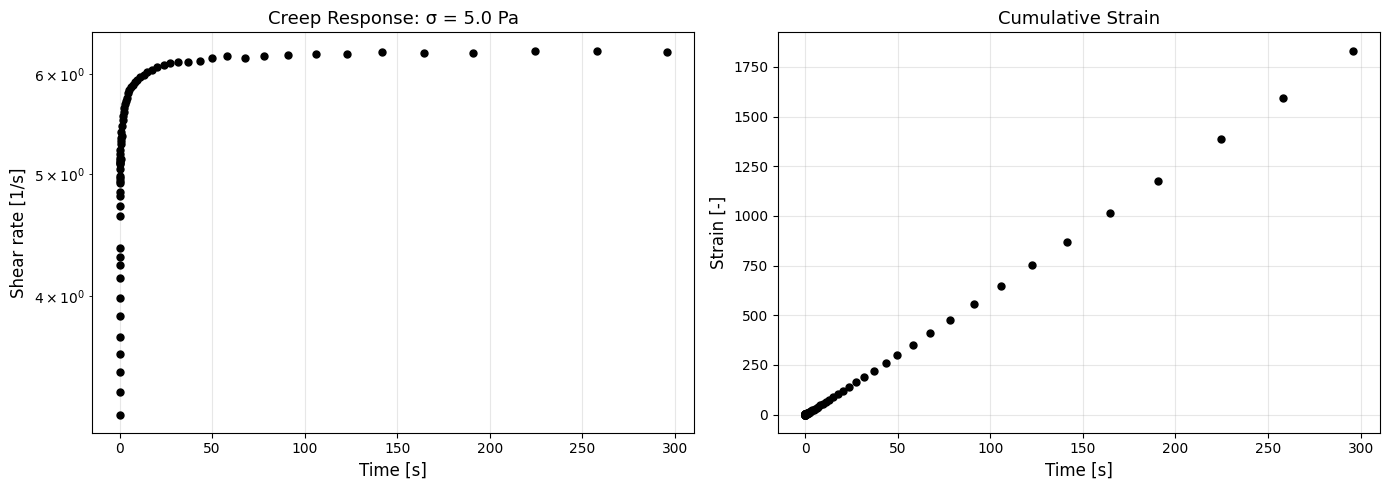

In [4]:
# Compute strain from shear rate (cumulative integration)
strain_data = np.cumsum(gamma_dot_data[:-1] * np.diff(time_data))
strain_data = np.insert(strain_data, 0, 0.0)

# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.semilogy(time_data, gamma_dot_data, "ko", markersize=5)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Shear rate [1/s]", fontsize=12)
ax1.set_title(f"Creep Response: σ = {sigma_final} Pa", fontsize=13)
ax1.grid(True, alpha=0.3)

ax2.plot(time_data, strain_data, "ko", markersize=5)
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Strain [-]", fontsize=12)
ax2.set_title("Cumulative Strain", fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit FIKH model
model = FIKH(include_thermal=False, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, strain_data, test_mode="creep", sigma_applied=sigma_final, method='scipy')
t_nlsq = time.time() - t0

param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

NLSQ fit time: 29.87 s

Fitted parameters:
  G               = 1000
  eta             = 0.8115
  C               = 500
  gamma_dyn       = 1
  m               = 1
  sigma_y0        = 10
  delta_sigma_y   = 50
  tau_thix        = 1
  Gamma           = 0.5
  alpha_structure = 0.7
  eta_inf         = 0.1
  mu_p            = 0.001



Fit Quality:
  R^2:   0.999908
  RMSE:  3.745


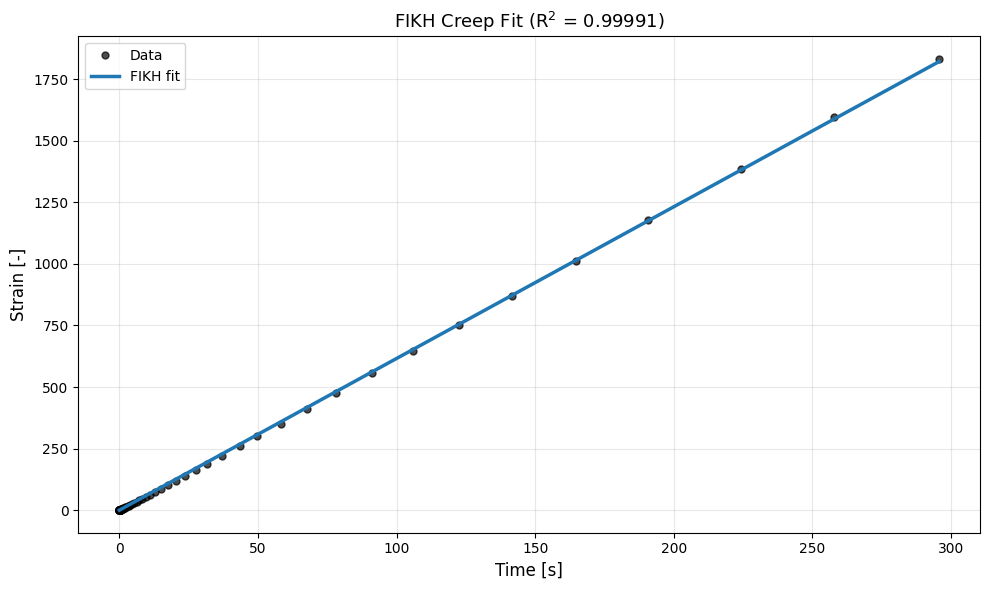

In [6]:
# Compute fit quality and plot
strain_pred = model.predict(time_data, test_mode="creep", sigma_applied=sigma_final)
metrics = compute_fit_quality(strain_data, strain_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g}")

time_fine = np.linspace(time_data.min(), time_data.max(), 300)
strain_pred_fine = model.predict(time_fine, test_mode="creep", sigma_applied=sigma_final)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, strain_data, "ko", markersize=5, alpha=0.7, label="Data")
ax.plot(time_fine, strain_pred_fine, "-", lw=2.5, color="C0", label="FIKH fit")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Strain [-]", fontsize=12)
ax.set_title(f"FIKH Creep Fit (R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Exploration

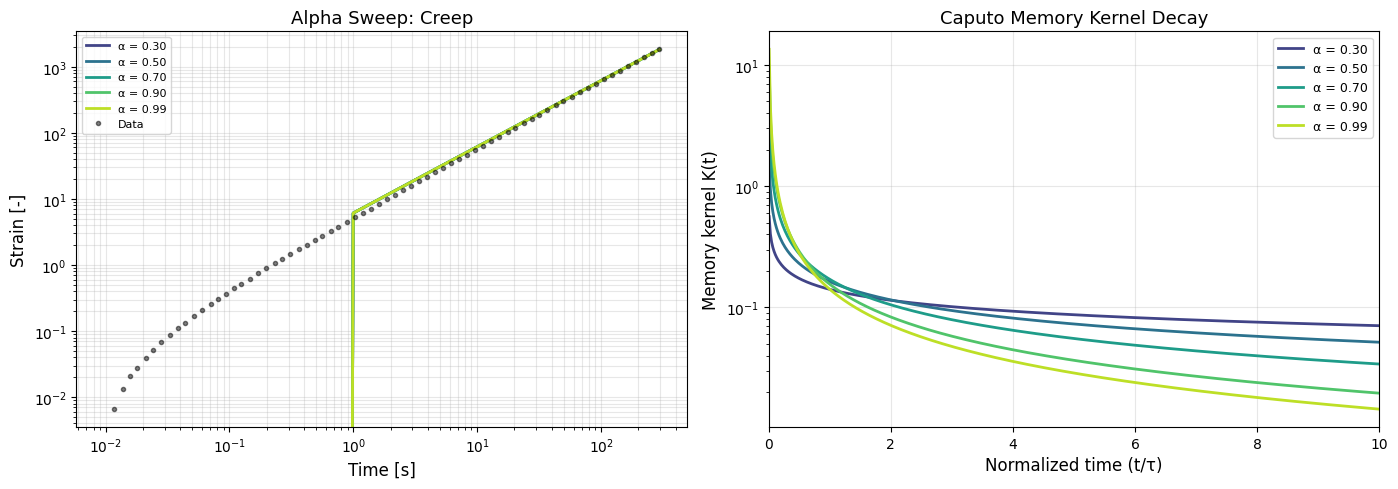

In [7]:
# Alpha sweep for creep
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="creep",
    alpha_values=alpha_values,
    x_data=time_fine,
    sigma_applied=sigma_final,
    figsize=(14, 5),
)

fig.axes[0].plot(time_data, strain_data, "ko", markersize=3, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

In [8]:
# Physical interpretation
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.700

Regime: Weak Memory

Approaching classical behavior with mild power-law tails.
Recovery is mostly exponential with slow corrections.
Suitable for: Mildly thixotropic materials.

Physical Implications:
  • Memory kernel decay: t^(-0.70)
  • Recovery time scale: > τ_thix × Γ(1+0.70) = 0.91 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.70


## 6. Bayesian Inference

In [9]:
# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    time_data,
    strain_data,
    test_mode="creep",
    sigma_applied=sigma_final,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:03<37:05,  3.18s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 7/700 [00:03<04:11,  2.76it/s, 511 steps of size 6.51e-04. acc. prob=0.55]

warmup:   1%|▏         | 9/700 [00:03<03:18,  3.48it/s, 511 steps of size 5.58e-04. acc. prob=0.65]

warmup:   2%|▏         | 11/700 [00:04<03:05,  3.71it/s, 1023 steps of size 5.51e-04. acc. prob=0.71]

warmup:   2%|▏         | 13/700 [00:04<02:58,  3.86it/s, 1023 steps of size 6.24e-04. acc. prob=0.75]

warmup:   2%|▏         | 14/700 [00:04<02:53,  3.95it/s, 1023 steps of size 6.73e-04. acc. prob=0.77]

warmup:   2%|▏         | 15/700 [00:04<02:50,  4.03it/s, 1023 steps of size 5.42e-04. acc. prob=0.78]

warmup:   2%|▏         | 16/700 [00:05<02:47,  4.08it/s, 1023 steps of size 5.96e-04. acc. prob=0.79]

warmup:   2%|▏         | 17/700 [00:05<02:48,  4.06it/s, 1023 steps of size 6.47e-04. acc. prob=0.80]

warmup:   3%|▎         | 18/700 [00:05<02:43,  4.17it/s, 1023 steps of size 7.19e-04. acc. prob=0.82]

warmup:   3%|▎         | 19/700 [00:05<02:41,  4.21it/s, 1023 steps of size 4.38e-04. acc. prob=0.81]

warmup:   3%|▎         | 20/700 [00:06<02:40,  4.23it/s, 1023 steps of size 4.88e-04. acc. prob=0.82]

warmup:   3%|▎         | 21/700 [00:06<02:44,  4.12it/s, 1023 steps of size 5.44e-04. acc. prob=0.83]

warmup:   3%|▎         | 22/700 [00:06<02:41,  4.19it/s, 1023 steps of size 5.91e-04. acc. prob=0.84]

warmup:   3%|▎         | 23/700 [00:06<02:42,  4.16it/s, 1023 steps of size 6.24e-04. acc. prob=0.85]

warmup:   3%|▎         | 24/700 [00:07<02:48,  4.01it/s, 1023 steps of size 6.66e-04. acc. prob=0.85]

warmup:   4%|▎         | 25/700 [00:07<02:43,  4.14it/s, 1023 steps of size 7.38e-04. acc. prob=0.86]

warmup:   4%|▎         | 26/700 [00:07<02:48,  4.01it/s, 1023 steps of size 7.68e-04. acc. prob=0.86]

warmup:   4%|▍         | 27/700 [00:07<02:40,  4.19it/s, 1023 steps of size 8.53e-04. acc. prob=0.87]

warmup:   4%|▍         | 28/700 [00:08<02:36,  4.31it/s, 1023 steps of size 8.90e-04. acc. prob=0.87]

warmup:   4%|▍         | 29/700 [00:08<02:33,  4.38it/s, 1023 steps of size 6.51e-04. acc. prob=0.87]

warmup:   4%|▍         | 30/700 [00:08<02:37,  4.25it/s, 1023 steps of size 6.36e-04. acc. prob=0.87]

warmup:   4%|▍         | 31/700 [00:08<02:47,  3.99it/s, 1023 steps of size 7.08e-04. acc. prob=0.88]

warmup:   5%|▍         | 32/700 [00:09<02:46,  4.00it/s, 1023 steps of size 7.78e-04. acc. prob=0.88]

warmup:   5%|▍         | 33/700 [00:09<02:46,  4.01it/s, 1023 steps of size 8.62e-04. acc. prob=0.88]

warmup:   5%|▍         | 34/700 [00:09<02:45,  4.03it/s, 1023 steps of size 9.37e-04. acc. prob=0.89]

warmup:   5%|▌         | 35/700 [00:09<02:38,  4.21it/s, 1023 steps of size 9.66e-04. acc. prob=0.89]

warmup:   5%|▌         | 36/700 [00:10<02:36,  4.24it/s, 1023 steps of size 5.26e-04. acc. prob=0.89]

warmup:   5%|▌         | 37/700 [00:10<02:39,  4.15it/s, 1023 steps of size 5.80e-04. acc. prob=0.89]

warmup:   5%|▌         | 38/700 [00:10<02:37,  4.20it/s, 1023 steps of size 6.04e-04. acc. prob=0.89]

warmup:   6%|▌         | 39/700 [00:10<02:34,  4.27it/s, 1023 steps of size 6.30e-04. acc. prob=0.89]

warmup:   6%|▌         | 40/700 [00:10<02:33,  4.30it/s, 1023 steps of size 6.94e-04. acc. prob=0.90]

warmup:   6%|▌         | 41/700 [00:11<02:29,  4.42it/s, 1023 steps of size 4.94e-04. acc. prob=0.89]

warmup:   6%|▌         | 42/700 [00:11<02:29,  4.41it/s, 1023 steps of size 5.39e-04. acc. prob=0.90]

warmup:   6%|▌         | 43/700 [00:11<02:27,  4.44it/s, 1023 steps of size 5.83e-04. acc. prob=0.90]

warmup:   6%|▋         | 44/700 [00:11<02:28,  4.43it/s, 1023 steps of size 6.41e-04. acc. prob=0.90]

warmup:   6%|▋         | 45/700 [00:12<02:27,  4.45it/s, 1023 steps of size 6.77e-04. acc. prob=0.90]

warmup:   7%|▋         | 46/700 [00:12<02:31,  4.33it/s, 1023 steps of size 7.27e-04. acc. prob=0.90]

warmup:   7%|▋         | 47/700 [00:12<02:38,  4.13it/s, 1023 steps of size 7.85e-04. acc. prob=0.91]

warmup:   7%|▋         | 48/700 [00:12<02:39,  4.10it/s, 1023 steps of size 8.58e-04. acc. prob=0.91]

warmup:   7%|▋         | 49/700 [00:13<02:40,  4.05it/s, 1023 steps of size 8.84e-04. acc. prob=0.91]

warmup:   7%|▋         | 50/700 [00:13<02:37,  4.13it/s, 1023 steps of size 9.51e-04. acc. prob=0.91]

warmup:   7%|▋         | 51/700 [00:13<02:36,  4.16it/s, 1023 steps of size 5.45e-04. acc. prob=0.91]

warmup:   7%|▋         | 52/700 [00:13<02:33,  4.21it/s, 1023 steps of size 5.77e-04. acc. prob=0.91]

warmup:   8%|▊         | 53/700 [00:14<02:34,  4.19it/s, 1023 steps of size 5.52e-04. acc. prob=0.91]

warmup:   8%|▊         | 54/700 [00:14<02:31,  4.25it/s, 1023 steps of size 5.34e-04. acc. prob=0.91]

warmup:   8%|▊         | 55/700 [00:14<02:32,  4.24it/s, 1023 steps of size 5.81e-04. acc. prob=0.91]

warmup:   8%|▊         | 56/700 [00:14<02:30,  4.28it/s, 1023 steps of size 6.32e-04. acc. prob=0.91]

warmup:   8%|▊         | 57/700 [00:14<02:25,  4.41it/s, 1023 steps of size 6.15e-04. acc. prob=0.91]

warmup:   8%|▊         | 58/700 [00:15<02:28,  4.33it/s, 1023 steps of size 6.62e-04. acc. prob=0.92]

warmup:   8%|▊         | 59/700 [00:15<02:27,  4.35it/s, 1023 steps of size 7.13e-04. acc. prob=0.92]

warmup:   9%|▊         | 60/700 [00:15<02:25,  4.40it/s, 1023 steps of size 7.67e-04. acc. prob=0.92]

warmup:   9%|▊         | 61/700 [00:15<02:24,  4.42it/s, 1023 steps of size 6.51e-04. acc. prob=0.92]

warmup:   9%|▉         | 62/700 [00:16<02:22,  4.48it/s, 1023 steps of size 6.49e-04. acc. prob=0.92]

warmup:   9%|▉         | 63/700 [00:16<02:27,  4.33it/s, 1023 steps of size 6.75e-04. acc. prob=0.92]

warmup:   9%|▉         | 64/700 [00:16<02:29,  4.26it/s, 1023 steps of size 7.17e-04. acc. prob=0.92]

warmup:   9%|▉         | 65/700 [00:16<02:28,  4.29it/s, 1023 steps of size 7.62e-04. acc. prob=0.92]

warmup:   9%|▉         | 66/700 [00:17<02:29,  4.24it/s, 1023 steps of size 8.16e-04. acc. prob=0.92]

warmup:  10%|▉         | 67/700 [00:17<02:29,  4.25it/s, 1023 steps of size 8.65e-04. acc. prob=0.92]

warmup:  10%|▉         | 68/700 [00:17<02:26,  4.32it/s, 1023 steps of size 9.30e-04. acc. prob=0.93]

warmup:  10%|▉         | 69/700 [00:17<02:27,  4.26it/s, 1023 steps of size 9.38e-04. acc. prob=0.93]

warmup:  10%|█         | 70/700 [00:17<02:34,  4.07it/s, 1023 steps of size 9.85e-04. acc. prob=0.93]

warmup:  10%|█         | 71/700 [00:18<02:30,  4.17it/s, 1023 steps of size 1.02e-03. acc. prob=0.93]

warmup:  10%|█         | 72/700 [00:18<02:26,  4.28it/s, 1023 steps of size 1.09e-03. acc. prob=0.93]

warmup:  10%|█         | 73/700 [00:18<02:31,  4.14it/s, 1023 steps of size 8.70e-04. acc. prob=0.93]

warmup:  11%|█         | 74/700 [00:18<02:30,  4.17it/s, 1023 steps of size 9.25e-04. acc. prob=0.93]

warmup:  11%|█         | 75/700 [00:19<02:28,  4.21it/s, 1023 steps of size 9.76e-04. acc. prob=0.93]

warmup:  11%|█         | 76/700 [00:19<02:28,  4.20it/s, 1023 steps of size 1.04e-03. acc. prob=0.93]

warmup:  11%|█         | 77/700 [00:19<02:28,  4.19it/s, 1023 steps of size 1.01e-03. acc. prob=0.93]

warmup:  11%|█         | 78/700 [00:19<02:23,  4.33it/s, 1023 steps of size 8.77e-04. acc. prob=0.93]

warmup:  11%|█▏        | 79/700 [00:20<02:23,  4.31it/s, 1023 steps of size 7.82e-04. acc. prob=0.93]

warmup:  11%|█▏        | 80/700 [00:20<02:23,  4.32it/s, 1023 steps of size 7.69e-04. acc. prob=0.93]

warmup:  12%|█▏        | 81/700 [00:20<02:26,  4.23it/s, 1023 steps of size 8.12e-04. acc. prob=0.93]

warmup:  12%|█▏        | 82/700 [00:20<02:26,  4.21it/s, 1023 steps of size 8.66e-04. acc. prob=0.93]

warmup:  12%|█▏        | 83/700 [00:21<02:25,  4.25it/s, 1023 steps of size 5.04e-04. acc. prob=0.93]

warmup:  12%|█▏        | 84/700 [00:21<02:26,  4.21it/s, 1023 steps of size 5.38e-04. acc. prob=0.93]

warmup:  12%|█▏        | 85/700 [00:21<02:27,  4.16it/s, 1023 steps of size 5.67e-04. acc. prob=0.93]

warmup:  12%|█▏        | 86/700 [00:21<02:24,  4.26it/s, 1023 steps of size 5.33e-04. acc. prob=0.93]

warmup:  12%|█▏        | 87/700 [00:22<02:27,  4.16it/s, 1023 steps of size 5.58e-04. acc. prob=0.93]

warmup:  13%|█▎        | 88/700 [00:22<02:23,  4.28it/s, 1023 steps of size 5.91e-04. acc. prob=0.93]

warmup:  13%|█▎        | 89/700 [00:22<02:22,  4.28it/s, 1023 steps of size 5.99e-04. acc. prob=0.93]

warmup:  13%|█▎        | 90/700 [00:22<02:19,  4.37it/s, 1023 steps of size 6.38e-04. acc. prob=0.93]

warmup:  13%|█▎        | 91/700 [00:22<02:19,  4.36it/s, 1023 steps of size 6.06e-04. acc. prob=0.93]

warmup:  13%|█▎        | 92/700 [00:23<02:22,  4.28it/s, 1023 steps of size 6.33e-04. acc. prob=0.93]

warmup:  13%|█▎        | 93/700 [00:23<02:19,  4.34it/s, 1023 steps of size 6.68e-04. acc. prob=0.93]

warmup:  13%|█▎        | 94/700 [00:23<02:22,  4.26it/s, 1023 steps of size 7.09e-04. acc. prob=0.94]

warmup:  14%|█▎        | 95/700 [00:23<02:20,  4.29it/s, 1023 steps of size 5.76e-04. acc. prob=0.93]

warmup:  14%|█▎        | 96/700 [00:24<02:22,  4.24it/s, 1023 steps of size 6.00e-04. acc. prob=0.94]

warmup:  14%|█▍        | 97/700 [00:24<02:20,  4.30it/s, 1023 steps of size 5.83e-04. acc. prob=0.94]

warmup:  14%|█▍        | 98/700 [00:24<02:16,  4.41it/s, 1023 steps of size 6.18e-04. acc. prob=0.94]

warmup:  14%|█▍        | 99/700 [00:24<02:15,  4.42it/s, 1023 steps of size 6.37e-04. acc. prob=0.94]

warmup:  14%|█▍        | 100/700 [00:24<02:13,  4.49it/s, 1023 steps of size 6.53e-04. acc. prob=0.94]

warmup:  14%|█▍        | 101/700 [00:25<02:13,  4.49it/s, 1023 steps of size 6.65e-03. acc. prob=0.94]

warmup:  15%|█▍        | 102/700 [00:25<02:16,  4.39it/s, 1023 steps of size 6.84e-03. acc. prob=0.94]

warmup:  15%|█▍        | 103/700 [00:25<02:17,  4.34it/s, 1023 steps of size 7.07e-03. acc. prob=0.94]

warmup:  15%|█▍        | 104/700 [00:25<02:18,  4.29it/s, 1023 steps of size 7.27e-03. acc. prob=0.94]

warmup:  15%|█▌        | 105/700 [00:26<02:19,  4.25it/s, 1023 steps of size 7.52e-03. acc. prob=0.94]

warmup:  15%|█▌        | 106/700 [00:26<02:17,  4.33it/s, 1023 steps of size 7.79e-03. acc. prob=0.94]

warmup:  15%|█▌        | 107/700 [00:26<02:16,  4.33it/s, 1023 steps of size 8.02e-03. acc. prob=0.94]

warmup:  15%|█▌        | 108/700 [00:26<02:16,  4.34it/s, 1023 steps of size 8.27e-03. acc. prob=0.94]

warmup:  16%|█▌        | 109/700 [00:27<02:24,  4.08it/s, 1023 steps of size 8.53e-03. acc. prob=0.94]

warmup:  16%|█▌        | 110/700 [00:27<02:20,  4.20it/s, 1023 steps of size 8.68e-03. acc. prob=0.94]

warmup:  16%|█▌        | 111/700 [00:27<02:17,  4.29it/s, 1023 steps of size 8.94e-03. acc. prob=0.94]

warmup:  16%|█▌        | 112/700 [00:27<02:20,  4.18it/s, 1023 steps of size 9.22e-03. acc. prob=0.94]

warmup:  16%|█▌        | 113/700 [00:28<02:21,  4.15it/s, 1023 steps of size 9.49e-03. acc. prob=0.94]

warmup:  16%|█▋        | 114/700 [00:28<02:21,  4.13it/s, 1023 steps of size 9.70e-03. acc. prob=0.94]

warmup:  16%|█▋        | 115/700 [00:28<02:20,  4.17it/s, 1023 steps of size 9.93e-03. acc. prob=0.95]

warmup:  17%|█▋        | 116/700 [00:28<02:14,  4.34it/s, 1023 steps of size 1.01e-02. acc. prob=0.95]

warmup:  17%|█▋        | 117/700 [00:28<02:12,  4.41it/s, 1023 steps of size 1.04e-02. acc. prob=0.95]

warmup:  17%|█▋        | 118/700 [00:29<02:21,  4.12it/s, 1023 steps of size 1.07e-02. acc. prob=0.95]

warmup:  17%|█▋        | 119/700 [00:29<01:57,  4.94it/s, 511 steps of size 1.09e-02. acc. prob=0.95] 

warmup:  17%|█▋        | 120/700 [00:29<01:44,  5.55it/s, 511 steps of size 1.12e-02. acc. prob=0.95]

warmup:  17%|█▋        | 121/700 [00:29<01:52,  5.15it/s, 1023 steps of size 1.15e-02. acc. prob=0.95]

warmup:  17%|█▋        | 122/700 [00:29<02:00,  4.78it/s, 1023 steps of size 1.17e-02. acc. prob=0.95]

warmup:  18%|█▊        | 123/700 [00:30<02:00,  4.77it/s, 1023 steps of size 1.20e-02. acc. prob=0.95]

warmup:  18%|█▊        | 124/700 [00:30<01:47,  5.38it/s, 511 steps of size 1.23e-02. acc. prob=0.95] 

warmup:  18%|█▊        | 125/700 [00:30<01:56,  4.92it/s, 1023 steps of size 1.25e-02. acc. prob=0.95]

warmup:  18%|█▊        | 126/700 [00:30<02:02,  4.68it/s, 1023 steps of size 1.28e-02. acc. prob=0.95]

warmup:  18%|█▊        | 127/700 [00:30<01:46,  5.36it/s, 511 steps of size 1.31e-02. acc. prob=0.95] 

warmup:  18%|█▊        | 128/700 [00:31<01:53,  5.06it/s, 1023 steps of size 1.33e-02. acc. prob=0.95]

warmup:  18%|█▊        | 129/700 [00:31<01:58,  4.82it/s, 1023 steps of size 1.36e-02. acc. prob=0.95]

warmup:  19%|█▊        | 130/700 [00:31<01:42,  5.54it/s, 511 steps of size 1.39e-02. acc. prob=0.95] 

warmup:  19%|█▊        | 131/700 [00:31<01:32,  6.16it/s, 511 steps of size 1.41e-02. acc. prob=0.95]

warmup:  19%|█▉        | 132/700 [00:31<01:26,  6.59it/s, 511 steps of size 1.43e-02. acc. prob=0.95]

warmup:  19%|█▉        | 133/700 [00:31<01:37,  5.84it/s, 1023 steps of size 1.46e-02. acc. prob=0.95]

warmup:  19%|█▉        | 134/700 [00:32<01:26,  6.58it/s, 511 steps of size 1.48e-02. acc. prob=0.95] 

warmup:  19%|█▉        | 135/700 [00:32<01:36,  5.83it/s, 1023 steps of size 1.51e-02. acc. prob=0.95]

warmup:  19%|█▉        | 136/700 [00:32<01:30,  6.24it/s, 511 steps of size 1.54e-02. acc. prob=0.95] 

warmup:  20%|█▉        | 137/700 [00:32<01:46,  5.30it/s, 1023 steps of size 1.57e-02. acc. prob=0.95]

warmup:  20%|█▉        | 138/700 [00:32<01:34,  5.96it/s, 511 steps of size 1.60e-02. acc. prob=0.95] 

warmup:  20%|█▉        | 139/700 [00:32<01:25,  6.59it/s, 511 steps of size 1.63e-02. acc. prob=0.95]

warmup:  20%|██        | 140/700 [00:32<01:18,  7.13it/s, 511 steps of size 1.65e-02. acc. prob=0.95]

warmup:  20%|██        | 141/700 [00:33<01:23,  6.70it/s, 767 steps of size 1.67e-02. acc. prob=0.96]

warmup:  20%|██        | 142/700 [00:33<01:38,  5.69it/s, 1023 steps of size 1.70e-02. acc. prob=0.96]

warmup:  20%|██        | 143/700 [00:33<01:29,  6.25it/s, 511 steps of size 1.73e-02. acc. prob=0.96] 

warmup:  21%|██        | 144/700 [00:33<01:26,  6.39it/s, 511 steps of size 1.76e-02. acc. prob=0.96]

warmup:  21%|██        | 145/700 [00:33<01:20,  6.94it/s, 511 steps of size 1.79e-02. acc. prob=0.96]

warmup:  21%|██        | 146/700 [00:33<01:16,  7.29it/s, 511 steps of size 1.82e-02. acc. prob=0.96]

warmup:  21%|██        | 147/700 [00:34<01:16,  7.26it/s, 511 steps of size 1.85e-02. acc. prob=0.96]

warmup:  21%|██        | 148/700 [00:34<01:12,  7.66it/s, 511 steps of size 1.88e-02. acc. prob=0.96]

warmup:  21%|██▏       | 149/700 [00:34<01:12,  7.61it/s, 511 steps of size 1.90e-02. acc. prob=0.96]

warmup:  21%|██▏       | 150/700 [00:34<01:08,  8.08it/s, 511 steps of size 1.93e-02. acc. prob=0.96]

warmup:  22%|██▏       | 156/700 [00:34<00:25, 21.32it/s, 63 steps of size 4.49e-02. acc. prob=0.96] 

warmup:  23%|██▎       | 160/700 [00:34<00:20, 25.89it/s, 63 steps of size 4.29e-02. acc. prob=0.96]

warmup:  23%|██▎       | 164/700 [00:34<00:18, 29.30it/s, 63 steps of size 4.69e-02. acc. prob=0.96]

warmup:  24%|██▍       | 168/700 [00:34<00:17, 31.09it/s, 127 steps of size 5.17e-02. acc. prob=0.96]

warmup:  25%|██▍       | 173/700 [00:34<00:14, 36.13it/s, 63 steps of size 5.72e-02. acc. prob=0.96] 

warmup:  25%|██▌       | 178/700 [00:35<00:13, 39.63it/s, 127 steps of size 5.83e-02. acc. prob=0.96]

warmup:  26%|██▌       | 183/700 [00:35<00:12, 42.46it/s, 63 steps of size 5.29e-02. acc. prob=0.96] 

warmup:  27%|██▋       | 188/700 [00:35<00:12, 41.78it/s, 63 steps of size 5.46e-02. acc. prob=0.96]

warmup:  28%|██▊       | 193/700 [00:35<00:11, 42.92it/s, 63 steps of size 5.09e-02. acc. prob=0.96]

warmup:  28%|██▊       | 199/700 [00:35<00:10, 45.86it/s, 63 steps of size 5.08e-02. acc. prob=0.96]

sample:  29%|██▉       | 204/700 [00:35<00:11, 41.80it/s, 63 steps of size 5.32e-02. acc. prob=0.98]

sample:  30%|███       | 210/700 [00:35<00:10, 45.39it/s, 63 steps of size 5.32e-02. acc. prob=0.98]

sample:  31%|███       | 215/700 [00:35<00:11, 41.80it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [00:36<00:11, 40.97it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  32%|███▏      | 226/700 [00:36<00:10, 43.83it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  33%|███▎      | 232/700 [00:36<00:09, 47.40it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  34%|███▍      | 237/700 [00:36<00:10, 44.64it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [00:36<00:09, 47.98it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  35%|███▌      | 248/700 [00:36<00:09, 46.48it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  36%|███▌      | 253/700 [00:36<00:09, 46.67it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  37%|███▋      | 259/700 [00:36<00:09, 47.16it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [00:36<00:09, 47.44it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  39%|███▊      | 270/700 [00:37<00:09, 46.10it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  39%|███▉      | 276/700 [00:37<00:08, 48.23it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  40%|████      | 281/700 [00:37<00:08, 47.81it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  41%|████      | 286/700 [00:37<00:09, 44.00it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [00:37<00:09, 44.89it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  43%|████▎     | 298/700 [00:37<00:08, 47.01it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  43%|████▎     | 303/700 [00:37<00:08, 44.93it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  44%|████▍     | 308/700 [00:37<00:08, 46.09it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [00:37<00:08, 45.47it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [00:38<00:08, 45.86it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  46%|████▋     | 324/700 [00:38<00:08, 46.78it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  47%|████▋     | 330/700 [00:38<00:07, 49.07it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  48%|████▊     | 336/700 [00:38<00:07, 51.16it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [00:38<00:07, 48.21it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  50%|████▉     | 347/700 [00:38<00:08, 43.24it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  51%|█████     | 354/700 [00:38<00:07, 46.31it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  51%|█████▏    | 359/700 [00:38<00:07, 43.71it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  52%|█████▏    | 364/700 [00:39<00:07, 43.43it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  53%|█████▎    | 369/700 [00:39<00:07, 44.84it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  54%|█████▎    | 375/700 [00:39<00:06, 46.43it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  54%|█████▍    | 380/700 [00:39<00:06, 46.08it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  55%|█████▌    | 385/700 [00:39<00:06, 46.41it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  56%|█████▌    | 391/700 [00:39<00:06, 50.01it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  57%|█████▋    | 397/700 [00:39<00:05, 51.85it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  58%|█████▊    | 403/700 [00:39<00:06, 49.17it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  58%|█████▊    | 408/700 [00:39<00:06, 47.27it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  59%|█████▉    | 415/700 [00:40<00:05, 51.93it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  60%|██████    | 421/700 [00:40<00:05, 49.84it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  61%|██████    | 427/700 [00:40<00:05, 46.89it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  62%|██████▏   | 433/700 [00:40<00:05, 48.15it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  63%|██████▎   | 438/700 [00:40<00:05, 47.25it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  64%|██████▎   | 445/700 [00:40<00:05, 49.14it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [00:40<00:05, 48.33it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  65%|██████▌   | 458/700 [00:40<00:04, 52.31it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  66%|██████▋   | 464/700 [00:41<00:04, 51.70it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  67%|██████▋   | 470/700 [00:41<00:04, 47.93it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  68%|██████▊   | 475/700 [00:41<00:05, 44.51it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  69%|██████▊   | 480/700 [00:41<00:04, 44.94it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  70%|██████▉   | 487/700 [00:41<00:04, 50.24it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  70%|███████   | 493/700 [00:41<00:04, 51.13it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  71%|███████▏  | 499/700 [00:41<00:04, 50.22it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  72%|███████▏  | 505/700 [00:42<00:04, 45.29it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [00:42<00:04, 46.78it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  74%|███████▎  | 516/700 [00:42<00:04, 43.34it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  74%|███████▍  | 521/700 [00:42<00:04, 42.84it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  75%|███████▌  | 526/700 [00:42<00:04, 43.49it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [00:42<00:03, 42.41it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  77%|███████▋  | 536/700 [00:42<00:03, 44.07it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [00:42<00:03, 47.59it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [00:42<00:03, 47.00it/s, 31 steps of size 5.32e-02. acc. prob=0.99]

sample:  79%|███████▉  | 553/700 [00:43<00:02, 49.45it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [00:43<00:02, 51.02it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  81%|████████  | 565/700 [00:43<00:02, 47.83it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  82%|████████▏ | 573/700 [00:43<00:02, 55.13it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  83%|████████▎ | 579/700 [00:43<00:02, 53.31it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  84%|████████▎ | 585/700 [00:43<00:02, 53.30it/s, 31 steps of size 5.32e-02. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [00:43<00:02, 53.42it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [00:43<00:01, 55.63it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  86%|████████▋ | 604/700 [00:43<00:01, 52.85it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  87%|████████▋ | 610/700 [00:44<00:01, 45.82it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [00:44<00:01, 45.86it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  89%|████████▊ | 621/700 [00:44<00:01, 48.73it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  90%|████████▉ | 627/700 [00:44<00:01, 48.60it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [00:44<00:01, 53.02it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [00:44<00:01, 53.08it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [00:44<00:01, 50.76it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [00:45<00:01, 45.83it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [00:45<00:00, 45.93it/s, 127 steps of size 5.32e-02. acc. prob=0.99]

sample:  95%|█████████▍| 664/700 [00:45<00:00, 48.62it/s, 63 steps of size 5.32e-02. acc. prob=0.99] 

sample:  96%|█████████▌| 669/700 [00:45<00:00, 44.54it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [00:45<00:00, 47.43it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [00:45<00:00, 46.33it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  98%|█████████▊| 686/700 [00:45<00:00, 48.61it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [00:45<00:00, 49.04it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [00:45<00:00, 46.95it/s, 63 steps of size 5.32e-02. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:46<00:00, 15.21it/s, 63 steps of size 5.32e-02. acc. prob=0.99]


Bayesian inference time: 51.1 s


In [10]:
# Convergence
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
            eta    1.0000       500      PASS
              C    1.0000       500      PASS
      gamma_dyn    1.0000       500      PASS
              m    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
  delta_sigma_y    1.0000       500      PASS
       tau_thix    1.0000       500      PASS
          Gamma    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
        eta_inf    1.0000       500      PASS
           mu_p    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


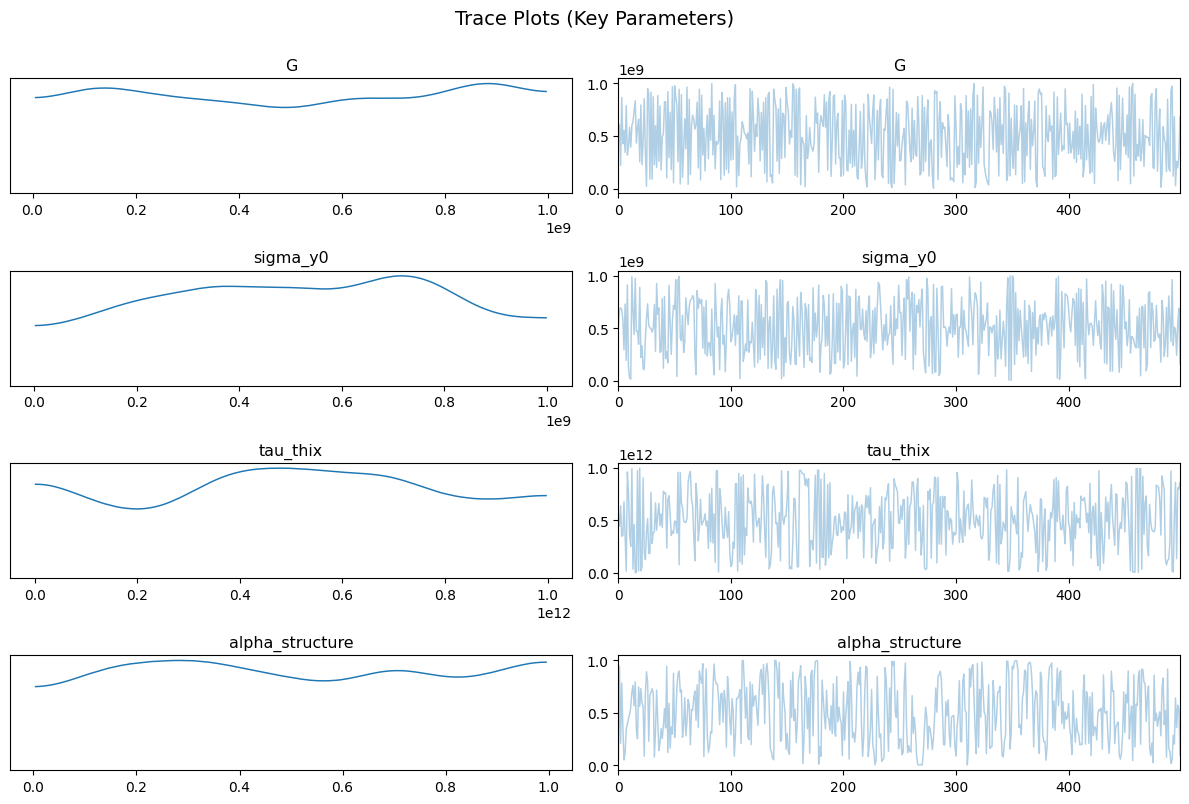

In [11]:
# Trace plots
idata = result.to_inference_data()
key_params = ["G", "sigma_y0", "tau_thix", "alpha_structure"]
axes = az.plot_trace(idata, var_names=key_params, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Key Parameters)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

In [12]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          1000     5.061e+08  [3.947e+07, 9.637e+08]
            eta        0.8115        0.8114  [0.8099, 0.8131]
              C           500     4.836e+08  [1.713e+07, 9.737e+08]
      gamma_dyn             1          5391  [113.3, 9946]
              m             1         1.738  [0.5532, 2.9]
       sigma_y0            10     5.122e+08  [4.376e+07, 9.665e+08]
  delta_sigma_y            50     5.125e+08  [1.068e+07, 9.789e+08]
       tau_thix             1     5.091e+11  [1.667e+10, 9.743e+11]
          Gamma           0.5          4906  [326.1, 9805]
alpha_structure           0.7        0.4801  [0.04603, 0.9866]
        eta_inf           0.1     4.776e+08  [2.733e+07, 9.735e+08]
           mu_p         0.001           509  [27.78, 973.8]


## 7. Save Results

In [13]:
save_fikh_results(model, result, "fikh", "creep", param_names)
print("\nResults saved.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/creep/
  nlsq_params_creep.json: 12 parameters
  posterior_creep.json: 500 draws

Results saved.


## Key Takeaways

1. **Creep reveals delayed yielding** with viscosity bifurcation
2. **Lower alpha** → stretched creep acceleration, slower yielding
3. **Higher alpha** → sharper yield transition (classical)
4. **Creep data constrains yield parameters** (sigma_y0, delta_sigma_y)
5. **Combined protocols** (flow curve + creep) improve alpha estimation

### Next Steps

- **NB05**: SAOS (frequency response)
- **NB06**: LAOS (nonlinear oscillatory)